<a href="https://colab.research.google.com/github/Felipepa9/MADSI/blob/main/Secci%C3%B3n_1_MOD_SIST_INT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-fuzzy

In [2]:
%load_ext autoreload
%reload_ext autoreload
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")

In [4]:
data = pd.read_csv('/content/drive/MyDrive/MOD. Y SIST. INTELIGENTES/SECCION_1.csv')
data.head()

,flight_num,taxi_fuel_kg_qty,trip_fuel_kg_qty,reserve_fuel_kg_qty,alternate_fuel_kg_qty,hold_altern_fuel_kg_qty,extra_fuel_kg_qty,RENTABILIDAD
0,13,800,15450,773,2298,2137,0,1
1,17,800,14740,737,3032,2060,0,1
2,13,800,15035,752,2320,2094,0,1
3,18,800,15240,762,2342,2094,0,1
4,20,800,16054,803,2330,2116,0,1


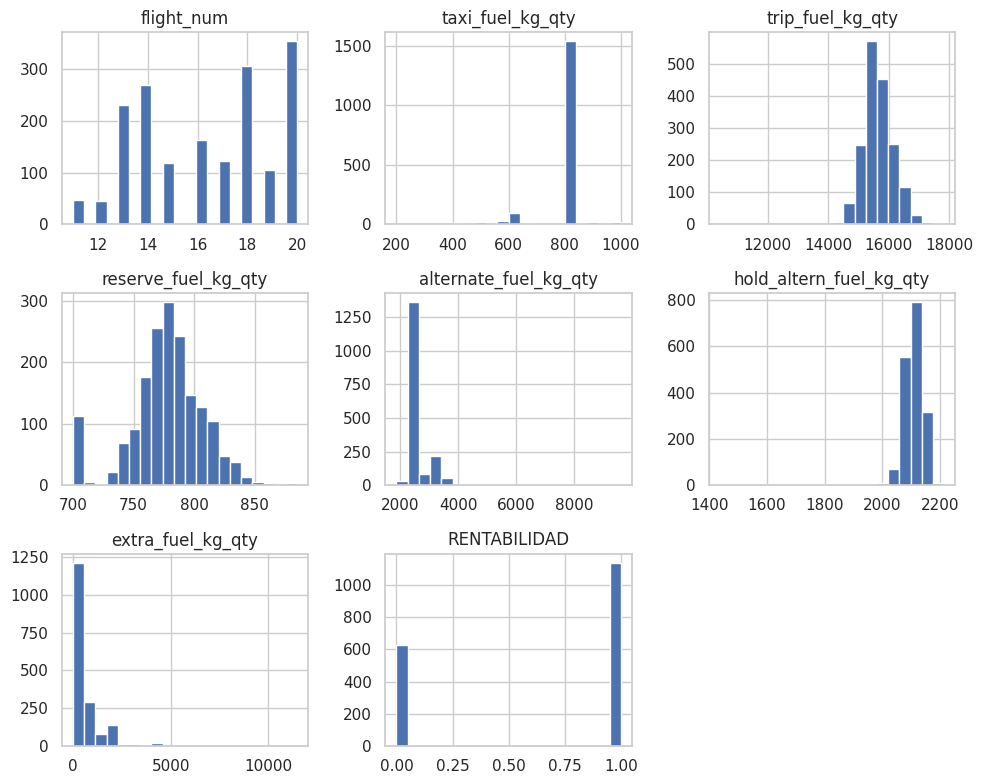

In [7]:
data.hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()

In [ ]:
def evaluar_sistema_fuzzy(simulator, df, feature_names, target_names):
    """
    Evalúa el sistema fuzzy con los datos de prueba.

    Args:
        simulator (ctrl.ControlSystemSimulation): Simulador del sistema fuzzy.
        df (pd.DataFrame): DataFrame con los datos.
        feature_names (list): Lista de nombres de las características.
        target_names (list): Lista de nombres de las especies objetivo.
    """
    print("\nEvaluando el sistema fuzzy...")

    X = df[feature_names].values
    y = df['target'].values
    # Usar stratify=y para mantener la proporción de clases en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
    print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

    predictions = []
    fuzzy_outputs = []

    for i, sample in enumerate(X_test):
        simulator.input['sepal_length'] = sample[0]
        simulator.input['sepal_width'] = sample[1]
        simulator.input['petal_length'] = sample[2]
        simulator.input['petal_width'] = sample[3]

        try:
            simulator.compute()
            predicted_value = simulator.output['species']
            fuzzy_outputs.append(predicted_value) # Guardar la salida fuzzy

            # Umbrales ajustados para la desfusificación a clases discretas
            if predicted_value <= 0.75: # Más inclinado hacia setosa
                predicted_class = 0
            elif predicted_value <= 1.75: # Más inclinado hacia versicolor
                predicted_class = 1
            else:
                predicted_class = 2
            predictions.append(predicted_class)

            if i < 5: # Mostrar detalles para las primeras 5 muestras
                print(f"\nMuestra de Prueba {i+1}:")
                print(f"  Características: SL={sample[0]}, SW={sample[1]}, PL={sample[2]}, PW={sample[3]}")
                print(f"  Clase Real: {target_names[y_test[i]]} ({y_test[i]})")
                print(f"  Predicción: {target_names[predicted_class]} ({predicted_class})")
                print(f"  Valor Fuzzy de Salida: {predicted_value:.4f}")

        except Exception as e: # Captura de errores más específica
            print(f"Error al procesar la muestra {i+1}: {sample}. Error: {e}")
            # Algunas entradas pueden no activar ninguna regla si las reglas son muy específicas
            # o si las funciones de pertenencia no cubren bien el espacio.
            # En estos casos, skfuzzy puede no devolver un output o dar error.
            predictions.append(-1) # Indicar error
            fuzzy_outputs.append(np.nan)

    # Asegurarse de que valid_indices solo contiene índices válidos
    # Esta es la línea clave que corrige el error
    valid_indices = [i for i, pred in enumerate(predictions) if pred != -1 and i < len(y_test)]

    if len(valid_indices) < len(predictions):
        print(f"\nADVERTENCIA: {len(predictions) - len(valid_indices)} muestras no pudieron ser clasificadas (ninguna regla activada).")

    valid_predictions = np.array(predictions)[valid_indices]
    valid_targets = y_test[valid_indices]

    if len(valid_predictions) > 0:
        accuracy = np.sum(valid_predictions == valid_targets) / len(valid_predictions)
        print(f"\nPrecisión del sistema fuzzy en el conjunto de prueba: {accuracy:.4f}")

        # Visualizar la distribución de las salidas fuzzy (opcional)
        plt.figure(figsize=(8, 5))
        sns.histplot(fuzzy_outputs, bins=15, kde=True)
        plt.title("Distribución de los Valores Fuzzy de Salida (species)")
        plt.xlabel("Valor Fuzzy")
        plt.ylabel("Frecuencia")
        plt.show()
    else:
        print("\nNo se pudieron obtener predicciones válidas para evaluar el sistema.")